# Synthetic Data Generation

We will use a pre-tuned model to produce data. The model output should be a 3D array with condition, signaling node and time point for dimensions. The model output will be sub-sampled to produce the synthetic dataset.

In [93]:
import torch
import numpy
import bionetwork
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as p9

## Run the pre-trained model

Run pre-trained model to produce synthetic data that are going to be used to evaluate the toy model. We will store both `fullYfull` which is the Y for all model states as well as the `X` that we used.

Prepare `X` and `fullYFull` for sub-sampling. `X` should be a matrix with Drug and Cell line as indexes and Targeted genes as columns. `fullYFull` should be matrix with Drug, Cell line, and Gene as indexes and Time points as columns.

The Cell line is also simulated by randomizing the bias randomly for each cell line and then run the model.

In [77]:
# Setup Parameters
N = 200
inputAmplitude = 3
projectionAmplitude = 1.2
seed = 123
torch.manual_seed(seed)
numpy.random.seed(seed)

# Load network
networkList, nodeNames, modeOfAction = bionetwork.loadNetwork('data/KEGGnet-Model.tsv')
annotation = pandas.read_csv('data/KEGGnet-Annotation.tsv', sep='\t')
bionetParams = bionetwork.trainingParameters(iterations = 150, clipping=1, leak=0.01)

inName = annotation.loc[annotation['ligand'],'code'].values
outName = annotation.loc[annotation['TF'],'code'].values
inName = numpy.intersect1d(nodeNames, inName)
outName = numpy.intersect1d(nodeNames, outName)

synthetic_data_combined = []
X_combined = []

# Generate data for 7 different cell lines
cell_line_names = [f"CL_{i}" for i in range(1, 7)]
celltype_factor = 1
for j, cell_line_name in enumerate(cell_line_names, start=1):
    celltype = j
    parameterizedModel = bionetwork.model(networkList, nodeNames, modeOfAction, inputAmplitude, projectionAmplitude, inName, outName, bionetParams, celltype=celltype, celltype_factor=celltype_factor)
    parameterizedModel = bionetwork.loadParam('data/equationParams.txt', parameterizedModel, nodeNames)

    # Generate data
    torch.manual_seed(123)
    X = torch.zeros(N, len(inName), dtype=torch.double)
    for i in range(1, N):  # Skip 0 to include a control sample i.e. zero input
        X[i, (i-1) % len(inName)] = torch.rand(1, dtype=torch.double)  # Stimulate each receptor at least once
        X[i, numpy.random.randint(0, len(inName))] = torch.rand(1, dtype=torch.double)

    Y, YfullRef, fullYFull = parameterizedModel(X)
    fullYFull = fullYFull.detach()

    # Transform fullYFull to a dataframe
    fullYFull_np = fullYFull.numpy()  # dimensions: conditions, node names, states

    dim1, dim2, dim3 = fullYFull_np.shape

    reshaped_array = fullYFull_np.reshape(dim1 * dim2, dim3)

    synthetic_data = pandas.DataFrame(reshaped_array)

    drug_names = [f"D_{i}" for i in range(1, dim1 + 1)]
    index = pandas.MultiIndex.from_product([drug_names, [cell_line_name], nodeNames], names=['Drug', 'Cell line', 'Signaling Node'])
    synthetic_data.index = index

    synthetic_data_combined.append(synthetic_data)
    
    # Transform X to a dataframe
    X = X.numpy()
    X = pandas.DataFrame(X)
    index = pandas.MultiIndex.from_product([drug_names, [cell_line_name]], names=['Drug', 'Cell line'])
    X.index = index
    X.columns = inName
    X_combined.append(X)
    
synthetic_data = pandas.concat(synthetic_data_combined)
X = pandas.concat(X_combined)
display(synthetic_data.head())
display(X.head())

0         1         2         3    \
Drug Cell line Signaling Node                                           
D_1  CL_1      O00206         -0.008835 -0.007168 -0.005301 -0.005364   
               O14492         -0.005292 -0.004752 -0.004308 -0.004308   
               O14511         -0.005200 -0.005200 -0.005200 -0.005200   
               O14640         -0.006763 -0.000726  0.562175  0.562175   
               O14727          0.112137  0.112106  0.112106  0.112106   

                                    4         5         6         7    \
Drug Cell line Signaling Node                                           
D_1  CL_1      O00206         -0.005358 -0.005353 -0.005353 -0.005353   
               O14492         -0.004308 -0.004308 -0.004308 -0.004308   
               O14511         -0.005200 -0.005200 -0.005200 -0.005200   
               O14640          0.562175  0.562175  0.562175  0.562175   
               O14727          0.112106  0.112106  0.112106  0.112106   

                                    8         9    ...  140  141  142  143  \
Drug Cell line Signaling Node                      ...                       
D_1  CL_1      O00206         -0.005353 -0.005353  ...  0.0  0.0  0.0  0.0   
               O14492         -0.004308 -0.004308  ...  0.0  0.0  0.0  0.0   
               O14511         -0.005200 -0.005200  ...  0.0  0.0  0.0  0.0   
               O14640          0.562175  0.562175  ...  0.0  0.0  0.0  0.0   
               O14727          0.112106  0.112106  ...  0.0  0.0  0.0  0.0   

                               144  145  146  147  148  149  
Drug Cell line Signaling Node                                
D_1  CL_1      O00206          0.0  0.0  0.0  0.0  0.0  0.0  
               O14492          0.0  0.0  0.0  0.0  0.0  0.0  
               O14511          0.0  0.0  0.0  0.0  0.0  0.0  
               O14640          0.0  0.0  0.0  0.0  0.0  0.0  
               O14727          0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 150 columns]

,,O14511,O14788,O14944,O43557,O75093,O75094,O75326,O94813,O96014,P00734,...,Q8NHW4,Q8WWG1,Q96A98,Q96B86,Q96S42,Q99075,Q9GZV9,Q9NPF7,Q9NSA1,Q9NT99
Drug,Cell line,,,,,,,,,,,,,,,,,,,,,
D_1,CL_1,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
D_2,CL_1,0.368896,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
D_3,CL_1,0.000000,0.59178,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.092639,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
D_4,CL_1,0.000000,0.00000,0.472452,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.522032,0.0,0.0
D_5,CL_1,0.000000,0.00000,0.000000,0.605083,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


## Sub-sample synthetic data

Sub-sample `fullYFull` by keeping only the # most variant Drugs across Cell lines and the first 18 time points with step 3 (to ensure we reached the steady state). Select the same Conditions for `X`.

In [78]:
n_conditions = 8
n_timepoints = 21
time_step = 3

#synthetic_data_filtered = synthetic_data.iloc[:, list(range(0, n_timepoints, time_step)) + [-1]]
synthetic_data_filtered = synthetic_data.iloc[:, :n_timepoints:time_step]

# Calculate the standard deviation for each condition to keep the ones with the heighest
variation = synthetic_data_filtered.groupby('Drug').std().mean(axis=1)
top_conditions = variation.nlargest(n_conditions).index
synthetic_data_filtered = synthetic_data_filtered.loc[top_conditions]

display(synthetic_data_filtered.head())

# Select the same Conditions for X
unique_conditions = synthetic_data_filtered.index.get_level_values('Drug').unique()
X_filtered = X.loc[unique_conditions]
display(X_filtered.head())

0         3         6         9   \
Drug  Cell line Signaling Node                                           
D_137 CL_1      O00206         -0.008835 -0.005364 -0.005353 -0.005353   
                O14492         -0.005292 -0.004308 -0.004308 -0.004308   
                O14511         -0.005200 -0.005200 -0.005200 -0.005200   
                O14640         -0.006763  0.562175  0.562175  0.562175   
                O14727          0.112137  0.112106  0.112106  0.112106   

                                      12        15        18  
Drug  Cell line Signaling Node                                
D_137 CL_1      O00206         -0.005353 -0.005353 -0.005353  
                O14492         -0.004308 -0.004308 -0.004308  
                O14511         -0.005200 -0.005200 -0.005200  
                O14640          0.562175  0.562175  0.562175  
                O14727          0.112106  0.112106  0.112106

O14511  O14788  O14944  O43557  O75093  O75094  O75326  \
Drug  Cell line                                                           
D_137 CL_1          0.0     0.0     0.0     0.0     0.0     0.0     0.0   
      CL_2          0.0     0.0     0.0     0.0     0.0     0.0     0.0   
      CL_3          0.0     0.0     0.0     0.0     0.0     0.0     0.0   
      CL_4          0.0     0.0     0.0     0.0     0.0     0.0     0.0   
      CL_5          0.0     0.0     0.0     0.0     0.0     0.0     0.0   

                 O94813  O96014  P00734  ...  Q8NHW4  Q8WWG1  Q96A98  Q96B86  \
Drug  Cell line                          ...                                   
D_137 CL_1          0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   
      CL_2          0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   
      CL_3          0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   
      CL_4          0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   
      CL_5          0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   

                 Q96S42  Q99075  Q9GZV9  Q9NPF7  Q9NSA1  Q9NT99  
Drug  Cell line                                                  
D_137 CL_1          0.0     0.0     0.0     0.0     0.0     0.0  
      CL_2          0.0     0.0     0.0     0.0     0.0     0.0  
      CL_3          0.0     0.0     0.0     0.0     0.0     0.0  
      CL_4          0.0     0.0     0.0     0.0     0.0     0.0  
      CL_5          0.0     0.0     0.0     0.0     0.0     0.0  

[5 rows x 101 columns]

### Plot Dynamics to Evaluate Sub-sampling

c:\Users\kanto\anaconda3\envs\deeplearning\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


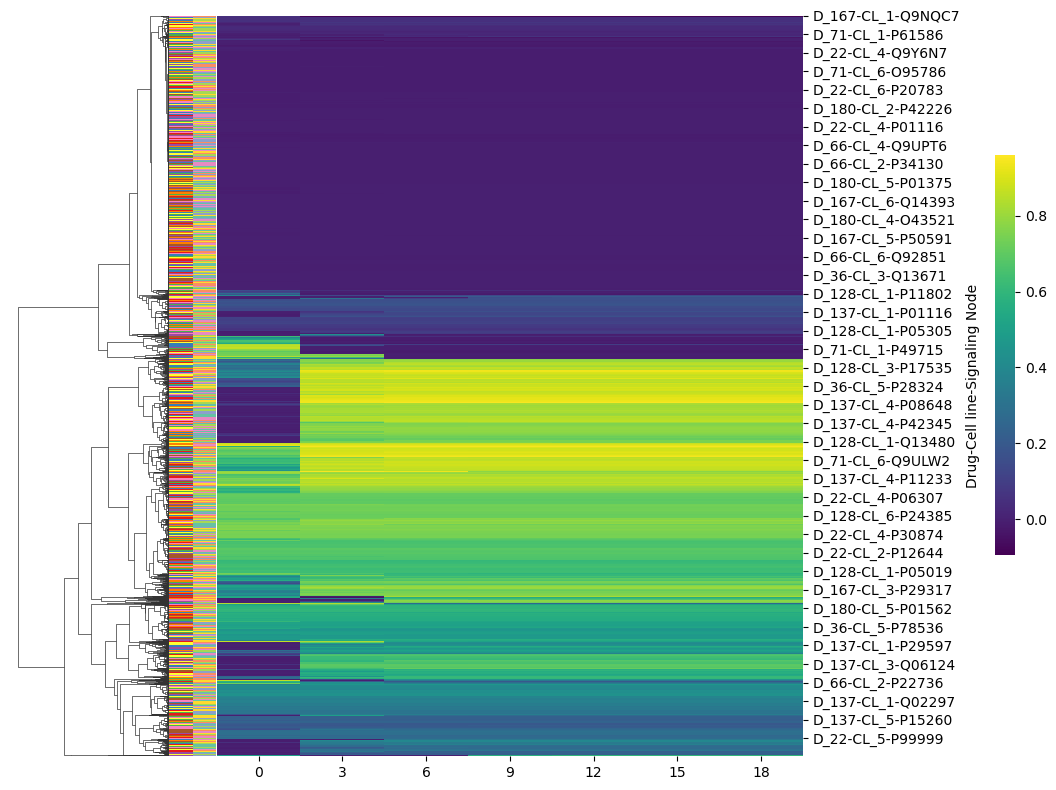

In [114]:
synthetic_data_plot = synthetic_data_filtered.copy()
annotations = synthetic_data_plot.index.to_frame(index=False)

drug_colors = sns.color_palette("Set1", len(annotations['Drug'].unique()))
cell_line_colors = sns.color_palette("Set2", len(annotations['Cell line'].unique()))

drug_lut = dict(zip(annotations['Drug'].unique(), drug_colors))
cell_line_lut = dict(zip(annotations['Cell line'].unique(), cell_line_colors))

row_colors = pandas.DataFrame({
    'Drug': annotations['Drug'].map(drug_lut),
    'Cell line': annotations['Cell line'].map(cell_line_lut)
})
drug_colors = row_colors['Drug']
cell_line_colors = row_colors['Cell line']

sns.clustermap(
    synthetic_data_plot, 
    cmap='viridis', 
    figsize=(10, 8), 
    col_cluster=False, 
    row_colors=[drug_colors, cell_line_colors], 
    cbar_pos=(1, 0.3, .02, .5),
    dendrogram_ratio=(.2, 0))
plt.show()

,Drug,Cell line,Signaling Node,Time,Value
0,D_137,CL_1,O43561,0,0.707496
1,D_137,CL_2,O43561,0,0.268809
2,D_137,CL_3,O43561,0,-0.000518
3,D_137,CL_4,O43561,0,-0.001337
4,D_137,CL_5,O43561,0,-0.003496


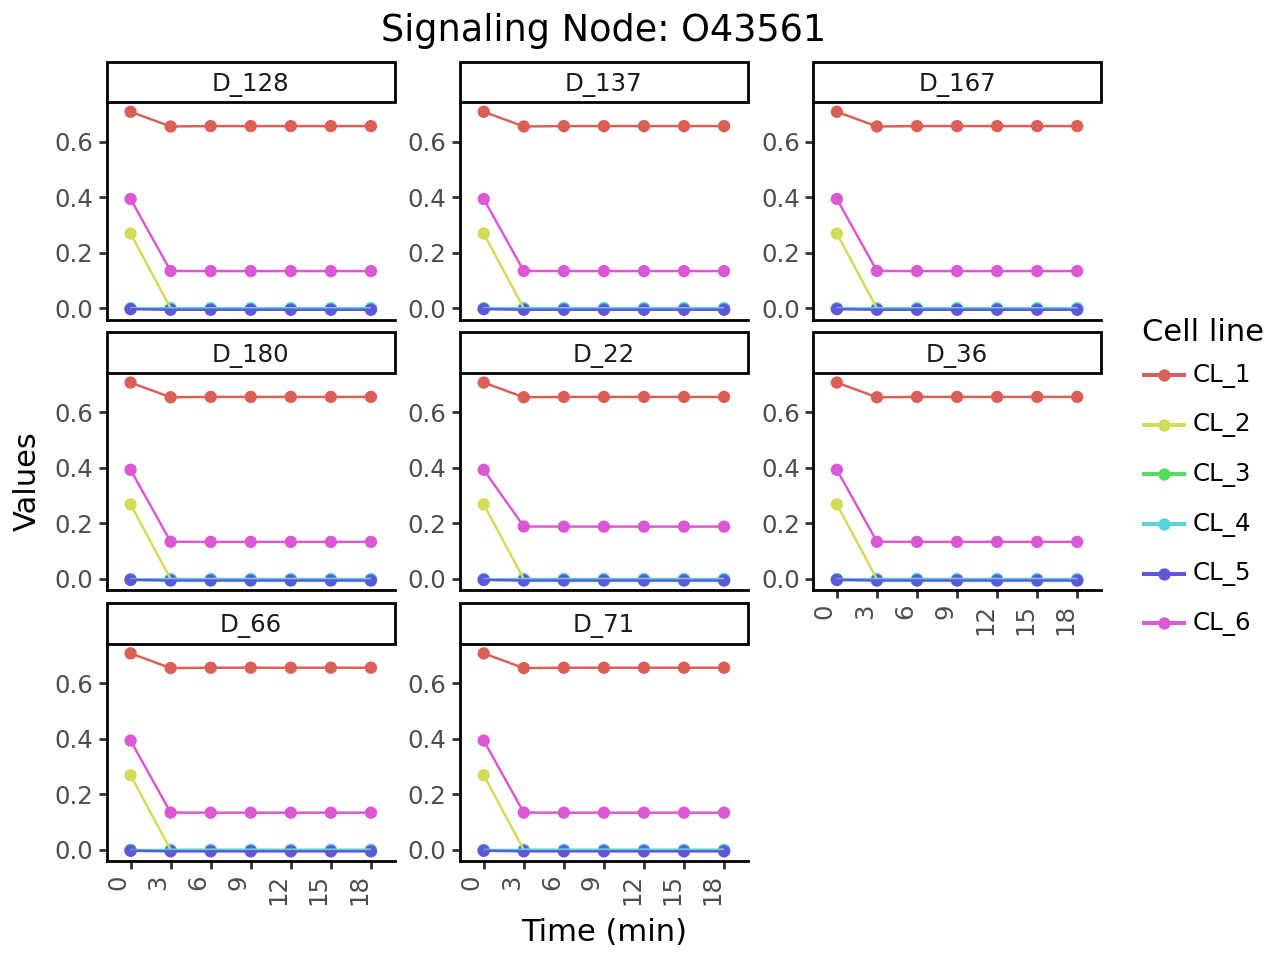

In [108]:
signaling_node = 'O43561'

idx = pandas.IndexSlice
specific_rows = synthetic_data_filtered.loc[idx[:, :, signaling_node], :]
specific_rows = specific_rows.reset_index()
specific_rows = specific_rows.melt(id_vars=['Drug', 'Cell line', 'Signaling Node'], var_name='Time', value_name='Value')
display(specific_rows.head())

plot = (p9.ggplot(specific_rows, p9.aes(x='Time', y='Value', color='Cell line', group='Cell line'))
        + p9.geom_point()
        + p9.geom_line()
        + p9.facet_wrap('~Drug', scales='free_y')
        + p9.labs(title=f'Signaling Node: {signaling_node}', x='Time (min)', y='Values')
        + p9.theme_classic()
        + p9.theme(axis_text_x=p9.element_text(rotation=90, hjust=1)))

plot.show()

## Process Data to be Exported

Reformat `fullYFull` in order to have common Condition_Time index and Genes as columns. Also, store mapping dataset (Condition_Time -> Time point), so we can track which Condition_Time maps to which Y time point when calculating the loss for the toy-model. Add the same Condition_Time to X by expanding it.

In [123]:
synthetic_data_melted = synthetic_data_filtered.reset_index().melt(id_vars=['Drug', 'Cell line', 'Signaling Node'], var_name='Time point', value_name='Value')
synthetic_data_melted['Drug_CL_Time'] = synthetic_data_melted['Drug'].astype(str) + '_' + synthetic_data_melted['Cell line'].astype(str) + '_' + synthetic_data_melted['Time point'].astype(str)
synthetic_data_pivoted = synthetic_data_melted.pivot(index='Drug_CL_Time', columns='Signaling Node', values='Value')
synthetic_data_final = synthetic_data_melted[['Drug_CL_Time', 'Time point']].drop_duplicates().set_index('Drug_CL_Time')
synthetic_data_final = synthetic_data_final.merge(synthetic_data_pivoted, left_index=True, right_index=True)

# Create a new mapping-dataset with Condition_Time and Time point
condition_time_df = synthetic_data_final[['Time point']].reset_index()

synthetic_data_final.drop(columns=['Time point'], inplace=True)  # Delete Time point column from the synthetic dataset

display(condition_time_df.head())
display(synthetic_data_final.head())

,Drug_CL_Time,Time point
0,D_137_CL_1_0,0
1,D_137_CL_2_0,0
2,D_137_CL_3_0,0
3,D_137_CL_4_0,0
4,D_137_CL_5_0,0


,O00206,O14492,O14511,O14640,O14727,O14733,O14763,O14788,O14920,O14944,...,Q9UPT6,Q9UQC2,Q9Y243,Q9Y2X7,Q9Y4D1,Q9Y4H2,Q9Y4K3,Q9Y6K9,Q9Y6N7,Q9Y6Q6
Drug_CL_Time,,,,,,,,,,,,,,,,,,,,,
D_137_CL_1_0,-0.008835,-0.005292,-0.005200,-0.006763,0.112137,-0.009956,-0.001012,0.414923,-0.003333,0.002340,...,0.507434,0.728408,-0.000282,-0.004130,0.643207,-0.003921,0.186177,-0.001871,0.725949,0.678012
D_137_CL_2_0,0.698627,-0.007844,0.428974,0.050041,0.697526,-0.001631,-0.007822,-0.004679,-0.001073,-0.000665,...,0.364918,-0.005669,0.411855,0.696736,0.053247,0.704619,-0.000803,-0.007836,-0.009919,-0.004247
D_137_CL_3_0,-0.009374,-0.004048,0.551409,-0.006806,0.510514,0.002007,-0.006256,-0.001350,-0.006832,0.558385,...,-0.004571,-0.002132,-0.009710,0.210221,0.755613,0.140533,0.587755,0.647650,0.740823,0.041515
D_137_CL_4_0,-0.000514,0.485037,-0.008734,0.707887,0.721376,-0.001119,-0.002029,0.516745,-0.012771,-0.000849,...,-0.007371,-0.000916,-0.002223,0.732326,0.069632,0.263092,-0.007465,0.651912,-0.009246,-0.003913
D_137_CL_5_0,0.278445,-0.004588,-0.002669,-0.004002,-0.004678,0.488363,0.135553,0.438285,0.201960,-0.000849,...,-0.010003,0.640521,0.685866,-0.004885,-0.007652,-0.002356,0.173742,0.106717,0.694452,-0.002082


In [120]:
"""X['Condition'] = X.index
X_final = X.loc[X.index.repeat(dim3)].reset_index(drop=True)
X_final['Time point'] = numpy.tile(range(dim3), dim1)
X_final['Condition_Time'] = X_final['Condition'].astype(str) + '_' + X_final['Time point'].astype(str)
X_final.set_index('Condition_Time', inplace=True)
X_final.drop(columns=['Condition', 'Time point'], inplace=True)

X_final = X_final.loc[synthetic_data_final.index]"""
X_final = X_filtered
display(X_final.head())

O14511  O14788  O14944  O43557  O75093  O75094  O75326  \
Drug  Cell line                                                           
D_137 CL_1          0.0     0.0     0.0     0.0     0.0     0.0     0.0   
      CL_2          0.0     0.0     0.0     0.0     0.0     0.0     0.0   
      CL_3          0.0     0.0     0.0     0.0     0.0     0.0     0.0   
      CL_4          0.0     0.0     0.0     0.0     0.0     0.0     0.0   
      CL_5          0.0     0.0     0.0     0.0     0.0     0.0     0.0   

                 O94813  O96014  P00734  ...  Q8NHW4  Q8WWG1  Q96A98  Q96B86  \
Drug  Cell line                          ...                                   
D_137 CL_1          0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   
      CL_2          0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   
      CL_3          0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   
      CL_4          0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   
      CL_5          0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   

                 Q96S42  Q99075  Q9GZV9  Q9NPF7  Q9NSA1  Q9NT99  
Drug  Cell line                                                  
D_137 CL_1          0.0     0.0     0.0     0.0     0.0     0.0  
      CL_2          0.0     0.0     0.0     0.0     0.0     0.0  
      CL_3          0.0     0.0     0.0     0.0     0.0     0.0  
      CL_4          0.0     0.0     0.0     0.0     0.0     0.0  
      CL_5          0.0     0.0     0.0     0.0     0.0     0.0  

[5 rows x 101 columns]

## Export Data

In [124]:
synthetic_data_final.to_csv('data/synthetic_data_y.csv', index=True)
X_final.to_csv('data/synthetic_data_x.csv', index=True)
condition_time_df.to_csv('data/synthetic_data_xtime.csv', index=True)